In [107]:
import math
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Conv1D, Lambda, SimpleRNN
import matplotlib.pyplot as plt 
import pandas_datareader as web
plt.style.use('fivethirtyeight')

In [108]:
from os.path import dirname
dirPath = dirname(dirname(os.getcwd()))+"\TotalCleanedTest.csv"
dirPath
df = pd.read_csv(dirPath)
df['ent_regis'] = df['ent_regis'].apply(lambda x: '{0:0>2}'.format(x))
df['ent_resid'] = df['ent_resid'].apply(lambda x: '{0:0>2}'.format(x))
df['ent_ocurr'] = df['ent_ocurr'].apply(lambda x: '{0:0>2}'.format(x))
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])
df.head()

,ent_regis,ent_regis_nm,mun_regis,mun_regis_nm,ent_resid,ent_resid_nm,mun_resid,mun_resid_nm,ent_ocurr,ent_ocurr_nm,...,complicaro,lengua,ICD,detailCaus,Organ,ICD_Mex,detailCaus_Mex,organ_Mex,date_ocurr,month_year_ocurr
0,01,Aguascalientes,1005,Jesus Maria,01,Aguascalientes,1005,Jesus Maria,01,Aguascalientes,...,8,9,C34,"Tumor maligno de los bronquios o del pulmón, p...",Lungs,C34,"Tumor maligno de la tráquea, de los bronquios ...",Lungs,2012-03-06,2012-03-01
1,01,Aguascalientes,1011,San Francisco de los Romo,01,Aguascalientes,1011,San Francisco de los Romo,01,Aguascalientes,...,8,9,C71,"Tumor maligno del encéfalo, parte no especificada",Brain,C71,Tumor maligno del encéfalo,Brain,2012-02-25,2012-02-01
2,01,Aguascalientes,1003,Calvillo,01,Aguascalientes,1001,Aguascalientes,01,Aguascalientes,...,8,9,C67,"Tumor maligno de la vejiga urinaria, parte no ...",Bladder,C67,Tumor maligno de la vejiga urinaria,Bladder,2012-04-28,2012-04-01
3,01,Aguascalientes,1001,Aguascalientes,01,Aguascalientes,1001,Aguascalientes,01,Aguascalientes,...,8,9,C56,Tumor maligno del ovario,Ovary,C56,Tumor maligno del ovario,Ovary,2012-07-26,2012-07-01
4,01,Aguascalientes,1001,Aguascalientes,01,Aguascalientes,1001,Aguascalientes,01,Aguascalientes,...,8,9,C25,"Tumor maligno del páncreas, parte no especificada",Pancreas,C25,Tumor maligno del páncreas,Pancreas,2012-01-11,2012-01-01


In [109]:
def getTimeSeries(state):
    dff = df.loc[(df['ent_regis'] == state)]
    series = dff['date_ocurr'].value_counts().rename_axis('unique_values').reset_index(name='counts')
    series = series.sort_values(by=['unique_values'])
    series.reset_index(inplace=True)
    series = series.drop(columns=['index'])
    return series

In [110]:
series = getTimeSeries('20')

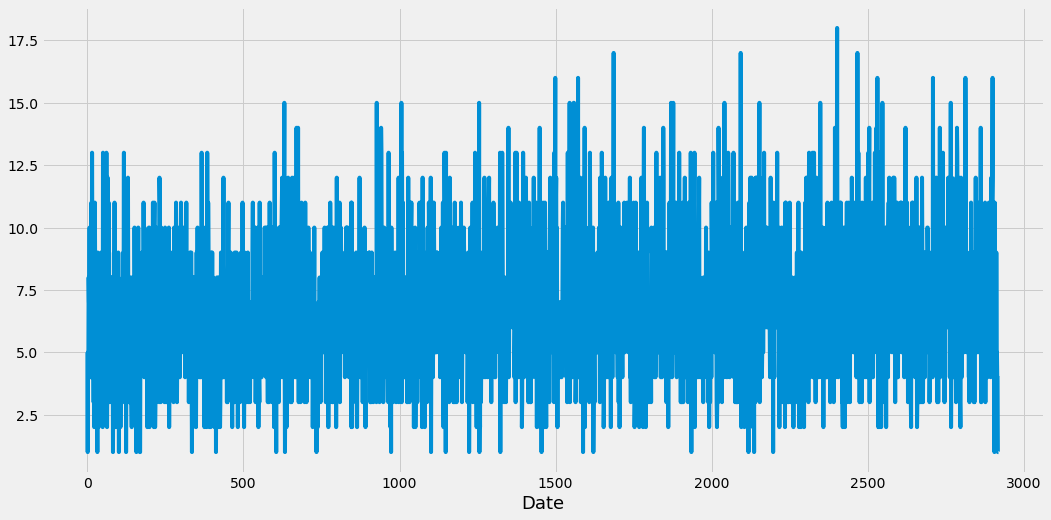

In [111]:
plt.figure(figsize=(16,8))
plt.plot(series['counts'])
plt.xlabel('Date',fontsize=18)
plt.show()

In [112]:
data = series.filter(['counts'])
dataset = data.values
dataset = dataset.astype('float32')

In [113]:
import statsmodels.api as sm
cycle, trend = sm.tsa.filters.hpfilter(series.counts, 1600)
gdp_decomp = series[['counts']]
gdp_decomp["cycle"] = cycle
gdp_decomp["trend"] = trend

gdp_decomp.head()

,counts,cycle,trend
0,5,0.001475,4.998525
1,1,-4.176556,5.176556
2,5,-0.354588,5.354588
3,4,-1.530011,5.530011
4,8,2.300005,5.699995


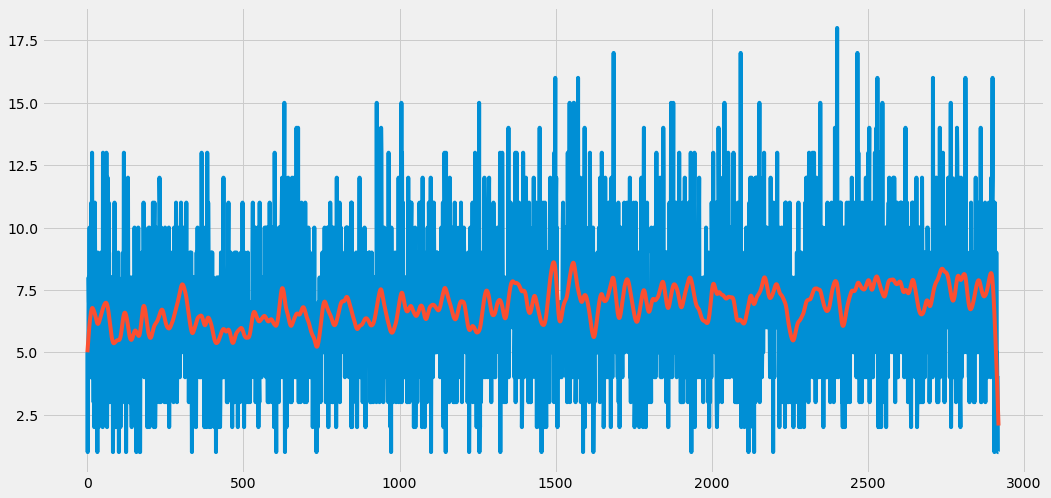

In [114]:
plt.figure(figsize=(16,8))
plt.plot(gdp_decomp[["counts", "trend"]])

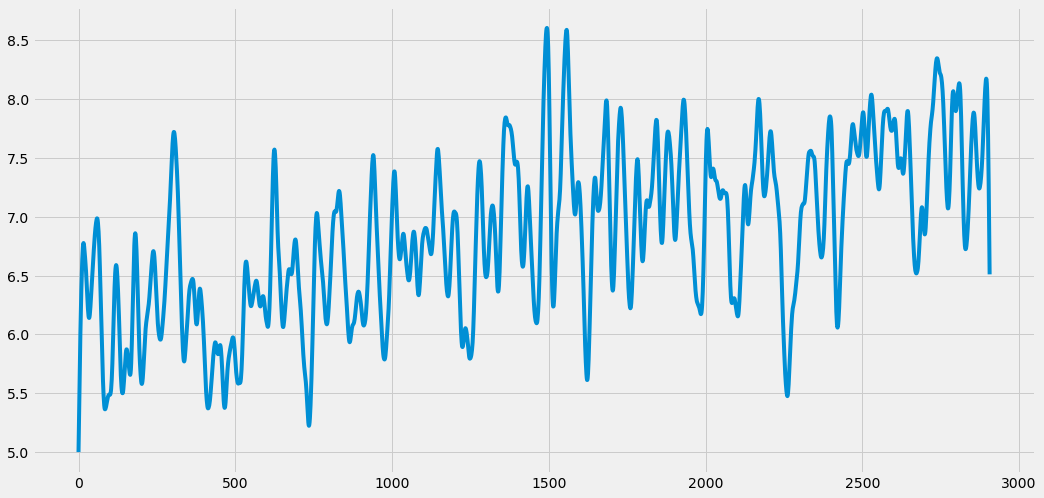

In [115]:
trend = gdp_decomp[["trend"]]
trend = trend[:2910]
plt.figure(figsize=(16,8))
plt.plot(trend)

In [116]:
trend.head()

,trend
0,4.998525
1,5.176556
2,5.354588
3,5.530011
4,5.699995


In [117]:
data = trend.filter(['trend'])
dataset = data.values
dataset

array([[4.99852532],
       [5.17655618],
       [5.35458796],
       ...,
       [7.03750332],
       [6.78108386],
       [6.51047123]])

In [118]:
training_data_len = math.ceil(len(dataset)*.80)
training_data_len

2326

In [119]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [120]:
train_data = scaled_data[0:training_data_len,:]
look_backs = 75

x_train = []
y_train = []

for i in range(look_backs, len(train_data)):
    x_train.append(train_data[i-look_backs:i,0])
    y_train.append(train_data[i,0])
    if i<=look_backs+1:
        print(x_train)
        print(y_train)
        print()

[array([0.        , 0.04934318, 0.09868662, 0.14730708, 0.19441991,
       0.23897542, 0.28032234, 0.31800674, 0.3517462 , 0.38192594,
       0.40888479, 0.43289639, 0.45380584, 0.47101471, 0.48346798,
       0.49085583, 0.49291302, 0.49045355, 0.48467652, 0.4768212 ,
       0.4678242 , 0.45832436, 0.44832195, 0.43787747, 0.42625183,
       0.41295217, 0.39825884, 0.38271403, 0.36695773, 0.35191065,
       0.33861088, 0.32805003, 0.32066187, 0.31684866, 0.31611957,
       0.3184789 , 0.32390685, 0.33218485, 0.34237245, 0.35384152,
       0.36609664, 0.37876798, 0.39160357, 0.40463465, 0.41764799,
       0.43035091, 0.44288288, 0.45511464, 0.46698684, 0.47884886,
       0.49058521, 0.50126172, 0.51102366, 0.52004972, 0.52802622,
       0.53483439, 0.5407186 , 0.54576243, 0.54936531, 0.55110551,
       0.55056464, 0.54732658, 0.54080461, 0.53145595, 0.51974656,
       0.50529079, 0.48720521, 0.46550339, 0.44058756, 0.41291572,
       0.38371012, 0.35376196, 0.32396932, 0.294663  , 0.2664

In [121]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2251, 75, 1)

In [122]:
model = Sequential() #initialize sequential model
model.add(LSTM(64,input_shape=(x_train.shape[1],1), return_sequences=True)) #LSTM layer with 32 neurons
model.add(LSTM(32, return_sequences=True)) #LSTM layer with 32 neurons
model.add(LSTM(32)) #LSTM layer with 32 neurons
model.add(Dense(16,activation='relu')) #Dense layer with 16 neurons
model.add(Dense(8,activation='relu')) #Dense layer with 8 neurons
model.add(Dense(1,activation='linear')) #Dense output layer with 1 neuron, linear activation

In [123]:
model.compile(loss='mse', optimizer='Adam', metrics=['mae'])

In [124]:
history = model.fit(x_train,y_train,batch_size=1,epochs=2)

Epoch 1/2
2251/2251 [==============================] - 62s 25ms/step - loss: 0.0116 - mae: 0.0676
Epoch 2/2
2251/2251 [==============================] - 57s 25ms/step - loss: 3.7843e-04 - mae: 0.0150


In [125]:
test_data = scaled_data[training_data_len - look_backs: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(look_backs, len(test_data)):
    x_test.append(test_data[i-look_backs:i, 0])

In [126]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [127]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [128]:
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.08459281614776705

In [129]:
train = trend[:training_data_len]
valid = trend[training_data_len:]
valid['Predictions'] = predictions
valid

<ipython-input-129-28b1427204aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


,trend,Predictions
2326,7.458860,7.367091
2327,7.490353,7.387882
2328,7.517267,7.418381
2329,7.536287,7.454169
2330,7.547528,7.484142
...,...,...
2902,7.494310,7.461530
2903,7.276372,7.240925
2904,7.037503,7.003253
2905,6.781084,6.756704


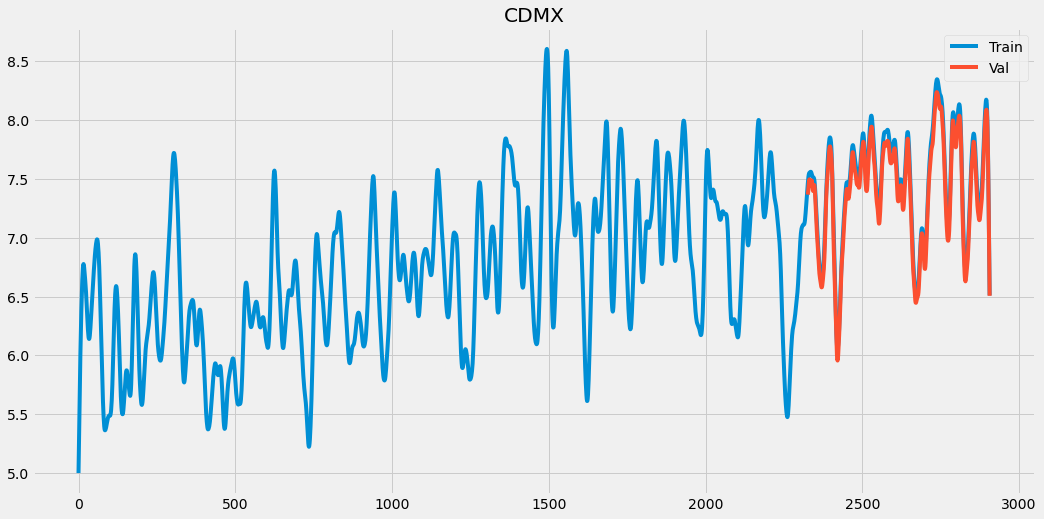

In [130]:
fig1 = plt.figure(figsize=(16,8))
plt.title("CDMX")
plt.plot(trend[["trend"]])
plt.plot(valid["Predictions"])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

In [156]:
predictions = []
df1 = trend.filter(['trend'])
dff = df1
add = df1.shape[0]
count = 0
while(1):
    if count == 15:
        break
    else:
        last_60_days = dff[-75:].values
        last_60_days_scaled = scaler.transform(last_60_days)
        X_test = []
        #Append the last 60 days
        X_test.append(last_60_days_scaled)
        #convert to a numpy array
        X_test = np.array(X_test)
        #reshape the data
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        #Get the predicted scaled value
        pred_val = model.predict(X_test)
        pred_cases = scaler.inverse_transform(pred_val)
        df1.loc[add+count+1] = pred_cases[0][0]
        dff = df1
        count = count+1

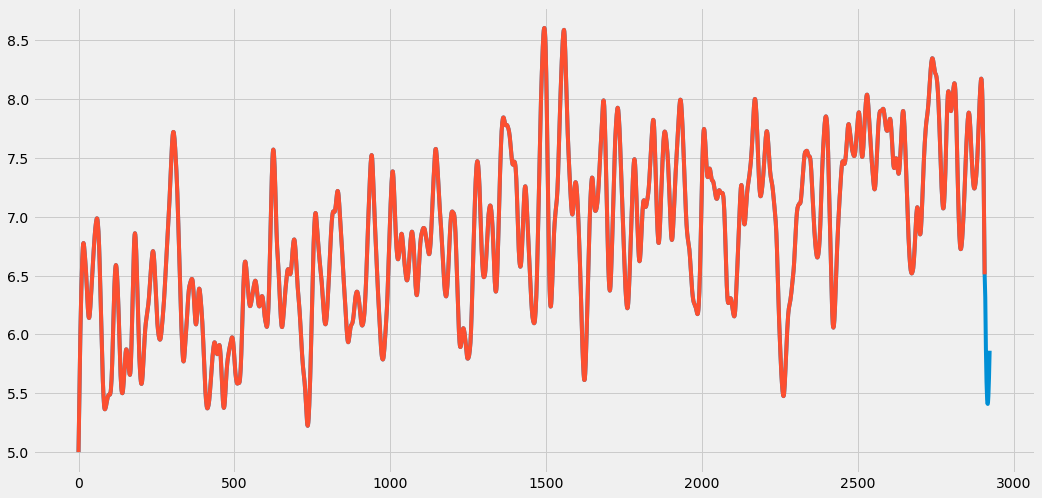

In [157]:
fig1 = plt.figure(figsize=(16,8))
plt.plot(df1)
plt.plot(trend[["trend"]])
plt.show()

In [158]:
print(f"{trend.shape}, {df1.shape}")

(2907, 1), (2922, 1)


In [159]:
data = df1.filter(['trend'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*.80)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
train_data = scaled_data[0:training_data_len,:]
look_backs = 75

x_train = []
y_train = []

for i in range(look_backs, len(train_data)):
    x_train.append(train_data[i-look_backs:i,0])
    y_train.append(train_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [160]:
model = Sequential() #initialize sequential model
model.add(LSTM(64,input_shape=(x_train.shape[1],1), return_sequences=True)) #LSTM layer with 32 neurons
model.add(LSTM(32, return_sequences=True)) #LSTM layer with 32 neurons
model.add(LSTM(32)) #LSTM layer with 32 neurons
model.add(Dense(16,activation='relu')) #Dense layer with 16 neurons
model.add(Dense(8,activation='relu')) #Dense layer with 8 neurons
model.add(Dense(1,activation='linear')) #Dense output layer with 1 neuron, linear activation
model.compile(loss='mse', optimizer='Adam', metrics=['mae'])
history = model.fit(x_train,y_train,batch_size=1,epochs=2)

Epoch 1/2
2263/2263 [==============================] - 61s 25ms/step - loss: 0.0107 - mae: 0.0682
Epoch 2/2
2263/2263 [==============================] - 56s 25ms/step - loss: 3.0736e-04 - mae: 0.0138


In [161]:
test_data = scaled_data[training_data_len - look_backs: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(look_backs, len(test_data)):
    x_test.append(test_data[i-look_backs:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
train = df1[:training_data_len]
valid = df1[training_data_len:]
valid['Predictions'] = predictions

<ipython-input-161-77dd3a49acbe>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


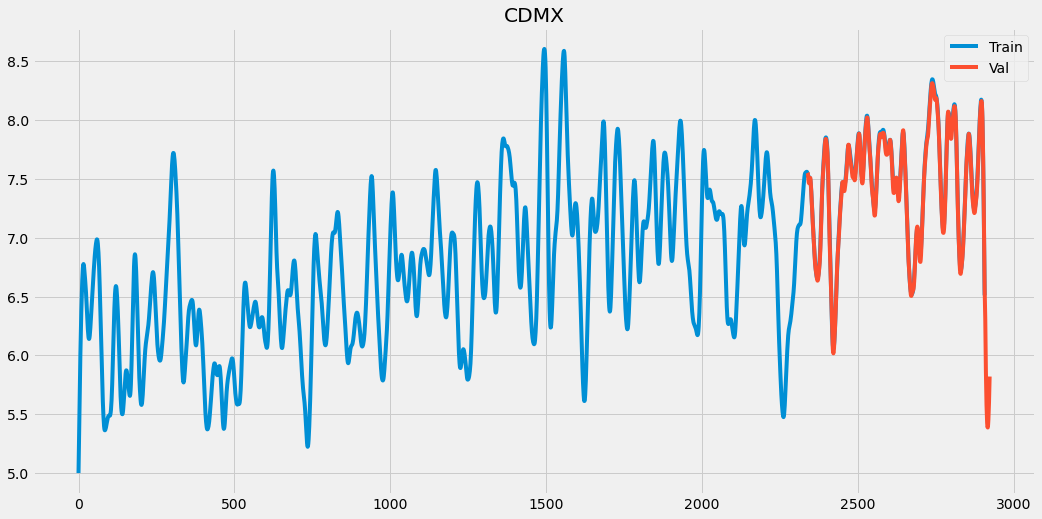

In [162]:
fig1 = plt.figure(figsize=(16,8))
plt.title("CDMX")
plt.plot(trend[["trend"]])
plt.plot(valid["Predictions"])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

In [169]:
predictions = []
df2 = df1.filter(['trend'])
dff = df2
add = df1.shape[0]
count = 0
while(1):
    if count == 15:
        break
    else:
        last_60_days = dff[-75:].values
        last_60_days_scaled = scaler.transform(last_60_days)
        X_test = []
        #Append the last 60 days
        X_test.append(last_60_days_scaled)
        #convert to a numpy array
        X_test = np.array(X_test)
        #reshape the data
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        #Get the predicted scaled value
        pred_val = model.predict(X_test)
        pred_cases = scaler.inverse_transform(pred_val)
        df2.loc[add+count+1] = pred_cases[0][0]
        dff = df2
        count = count+1

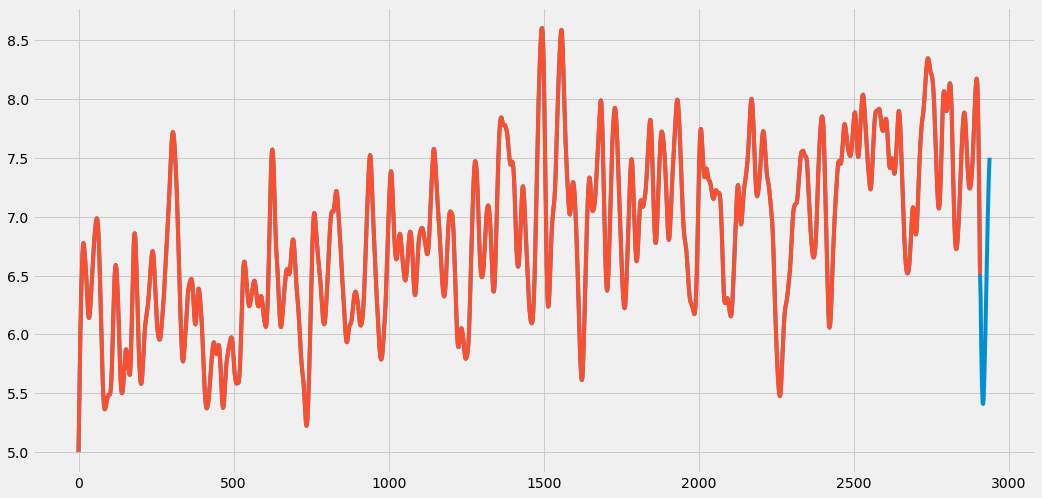

In [172]:
fig1 = plt.figure(figsize=(16,8))
plt.plot(df2)
plt.plot(trend[["trend"]])
plt.show()

In [173]:
print(f"{trend.shape}, {df1.shape}, {df2.shape}")

(2907, 1), (2922, 1), (2937, 1)


In [174]:
data = df2.filter(['trend'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*.80)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
train_data = scaled_data[0:training_data_len,:]
look_backs = 75

x_train = []
y_train = []

for i in range(look_backs, len(train_data)):
    x_train.append(train_data[i-look_backs:i,0])
    y_train.append(train_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [175]:
model = Sequential() #initialize sequential model
model.add(LSTM(64,input_shape=(x_train.shape[1],1), return_sequences=True)) #LSTM layer with 32 neurons
model.add(LSTM(32, return_sequences=True)) #LSTM layer with 32 neurons
model.add(LSTM(32)) #LSTM layer with 32 neurons
model.add(Dense(16,activation='relu')) #Dense layer with 16 neurons
model.add(Dense(8,activation='relu')) #Dense layer with 8 neurons
model.add(Dense(1,activation='linear')) #Dense output layer with 1 neuron, linear activation
model.compile(loss='mse', optimizer='Adam', metrics=['mae'])
history = model.fit(x_train,y_train,batch_size=1,epochs=2)

Epoch 1/2
2275/2275 [==============================] - 66s 27ms/step - loss: 0.0113 - mae: 0.0685
Epoch 2/2
2275/2275 [==============================] - 62s 27ms/step - loss: 4.1415e-04 - mae: 0.0160


In [177]:
test_data = scaled_data[training_data_len - look_backs: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(look_backs, len(test_data)):
    x_test.append(test_data[i-look_backs:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
train = df2[:training_data_len]
valid = df2[training_data_len:]
valid['Predictions'] = predictions

<ipython-input-177-cf22a27ed9a6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


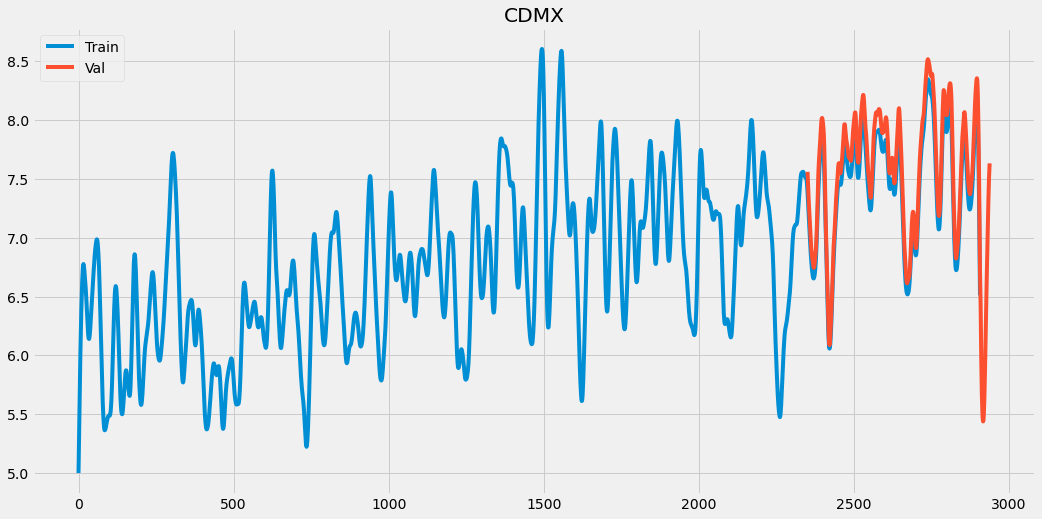

In [178]:
fig1 = plt.figure(figsize=(16,8))
plt.title("CDMX")
plt.plot(trend[["trend"]])
plt.plot(valid["Predictions"])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

In [179]:
predictions = []
df3 = df2.filter(['trend'])
dff = df3
add = df2.shape[0]
count = 0
while(1):
    if count == 15:
        break
    else:
        last_60_days = dff[-75:].values
        last_60_days_scaled = scaler.transform(last_60_days)
        X_test = []
        #Append the last 60 days
        X_test.append(last_60_days_scaled)
        #convert to a numpy array
        X_test = np.array(X_test)
        #reshape the data
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        #Get the predicted scaled value
        pred_val = model.predict(X_test)
        pred_cases = scaler.inverse_transform(pred_val)
        df3.loc[add+count+1] = pred_cases[0][0]
        dff = df3
        count = count+1

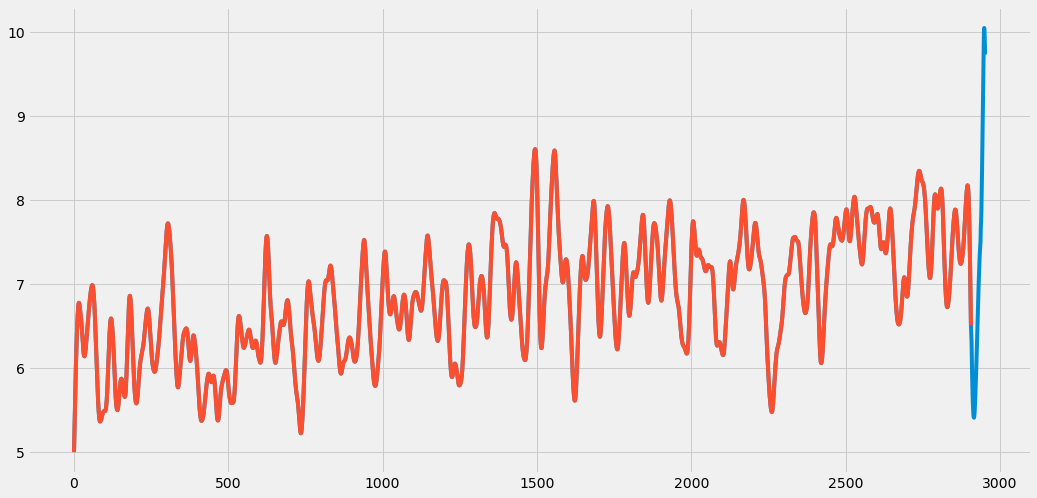

In [182]:
fig1 = plt.figure(figsize=(16,8))
plt.plot(df3)
plt.plot(trend[["trend"]])
plt.show()

In [181]:
print(f"{trend.shape}, {df1.shape}, {df2.shape}, {df3.shape}")

(2907, 1), (2922, 1), (2937, 1), (2952, 1)
